<a href="https://colab.research.google.com/github/vernon-chang/Design-and-Development-of-Autoencoders-to-Identify-Latent-Space-for-Protein-Dynamics/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The CVAE model for the MNIST data set**

In [ ]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import numpy as np
import tensorflow as tf

#load the data
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_size = 60000
batch_size = 32
test_size = 10000

#batch and shuffle the data
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

11501568/11490434 [==============================] - 0s 0us/step


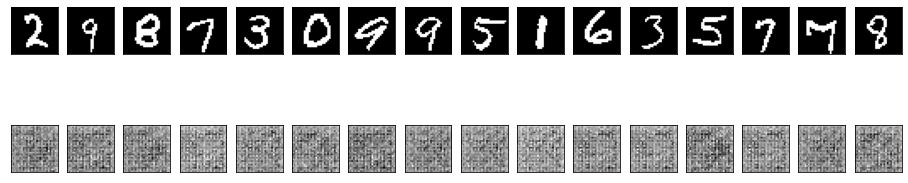

Epoch: 10, Test set ELBO: -156.23297119140625, time elapse for current epoch 82.72863864898682


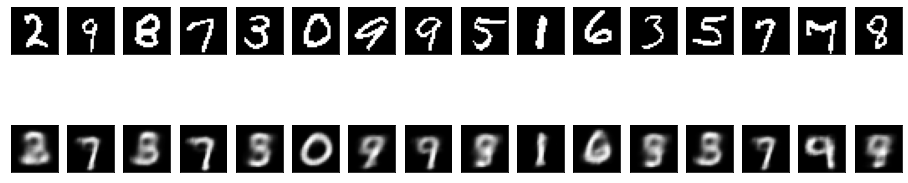

Epoch: 20, Test set ELBO: -153.1211700439453, time elapse for current epoch 82.34127950668335


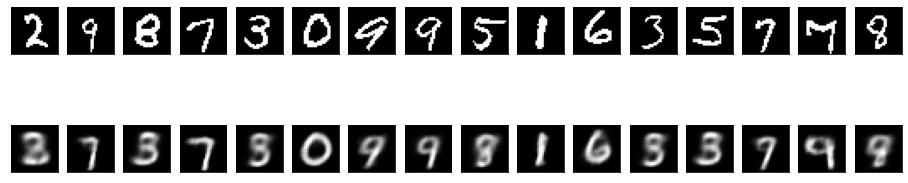

Epoch: 30, Test set ELBO: -152.10670471191406, time elapse for current epoch 83.14066481590271


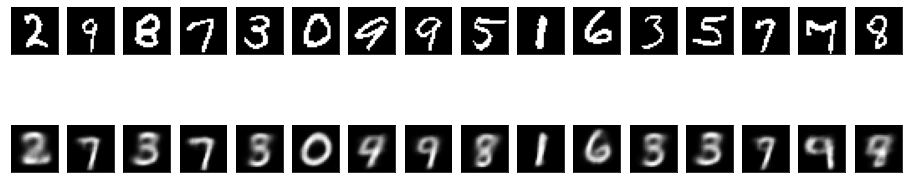

Epoch: 40, Test set ELBO: -151.2284393310547, time elapse for current epoch 82.44974136352539


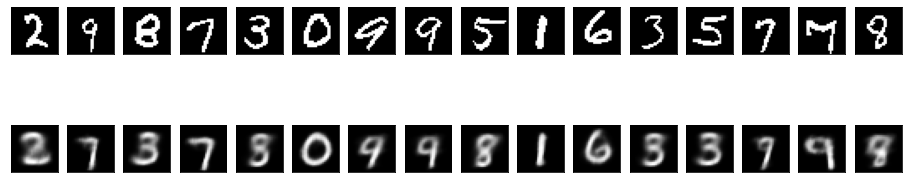

Epoch: 50, Test set ELBO: -150.11138916015625, time elapse for current epoch 82.93810558319092


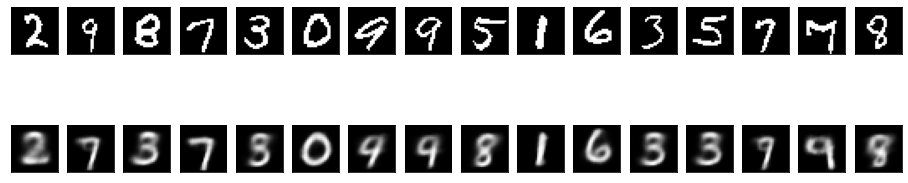

Epoch: 60, Test set ELBO: -149.710693359375, time elapse for current epoch 81.44694399833679


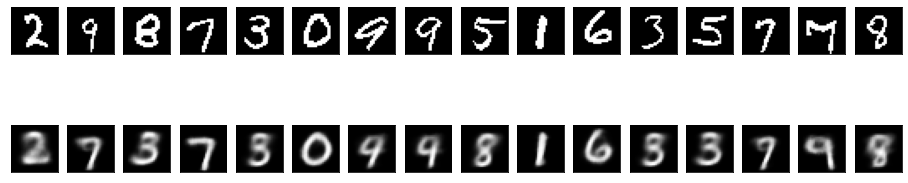

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

#the loss function
@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
    
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  

epochs = 100
latent_dim = 2
num_examples_to_generate = 16

# Keep the random vector constant for generation (prediction) to make it easier to see improvements.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)


def generate_and_save_images(model, epoch, test_sample):
  # Reconstruction
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(20, 4))
    for i in range(predictions.shape[0]):
            # display original
        ax = plt.subplot(2, 20, i + 1)
        test_sample = np.array(test_sample)
        plt.imshow(test_sample[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

            # display reconstruction
        ax = plt.subplot(2, 20, i + 1 + 20)
        plt.imshow(predictions[i,:,:,0])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

generate_and_save_images(model, 0, test_sample)
losses = []
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 10 == 0:
    loss = tf.keras.metrics.Mean()
    
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    losses.append(loss.result()) 
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, test_sample)
    
#plot the loss function image
t = np.arange(0,epoch,1)
plt.plot(t, losses)

# **The AAE model of the MNIST data set**

Loading data...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


   0: TIME: 82.16 ETA: 8215.85 AE_LOSS: 0.0714 DC_LOSS: 1.3353 DC_ACC: 0.6443 GEN_LOSS: 2.0695


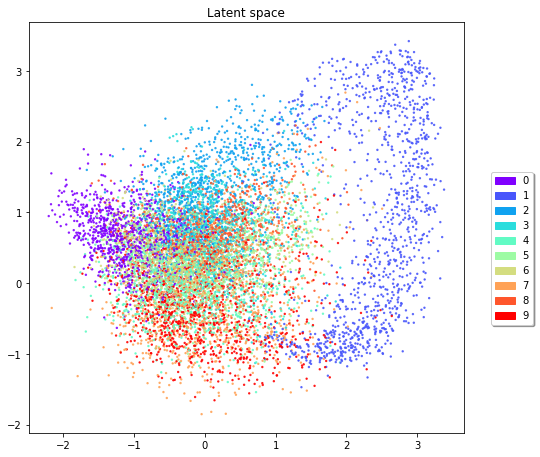

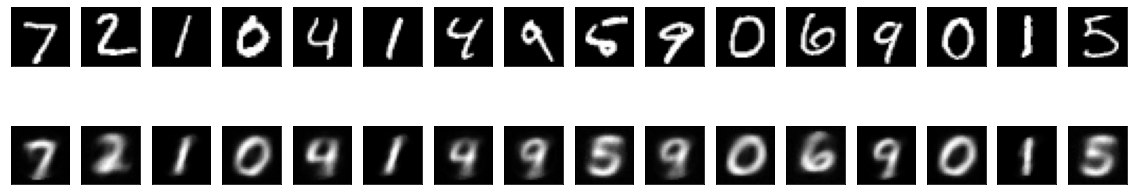

   1: TIME: 82.04 ETA: 8122.09 AE_LOSS: 0.0452 DC_LOSS: 1.3764 DC_ACC: 0.5506 GEN_LOSS: 0.7164
   2: TIME: 72.13 ETA: 7068.93 AE_LOSS: 0.0414 DC_LOSS: 1.3798 DC_ACC: 0.5315 GEN_LOSS: 0.7133
   3: TIME: 71.99 ETA: 6983.30 AE_LOSS: 0.0399 DC_LOSS: 1.3827 DC_ACC: 0.5226 GEN_LOSS: 0.6956
   4: TIME: 72.51 ETA: 6961.24 AE_LOSS: 0.0395 DC_LOSS: 1.3826 DC_ACC: 0.5176 GEN_LOSS: 0.6989
   5: TIME: 82.02 ETA: 7792.37 AE_LOSS: 0.0396 DC_LOSS: 1.3819 DC_ACC: 0.5144 GEN_LOSS: 0.7015
   6: TIME: 71.82 ETA: 6751.32 AE_LOSS: 0.0393 DC_LOSS: 1.3817 DC_ACC: 0.5122 GEN_LOSS: 0.7037
   7: TIME: 82.03 ETA: 7629.03 AE_LOSS: 0.0384 DC_LOSS: 1.3838 DC_ACC: 0.5106 GEN_LOSS: 0.6975
   8: TIME: 82.03 ETA: 7546.80 AE_LOSS: 0.0383 DC_LOSS: 1.3827 DC_ACC: 0.5093 GEN_LOSS: 0.6983
   9: TIME: 82.02 ETA: 7463.95 AE_LOSS: 0.0977 DC_LOSS: 35.9049 DC_ACC: 0.5098 GEN_LOSS: 351.4614
  10: TIME: 82.03 ETA: 7382.37 AE_LOSS: 0.1135 DC_LOSS: 2.6645 DC_ACC: 0.5289 GEN_LOSS: 32.0795


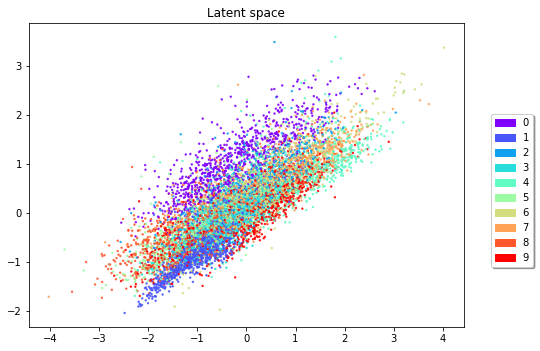

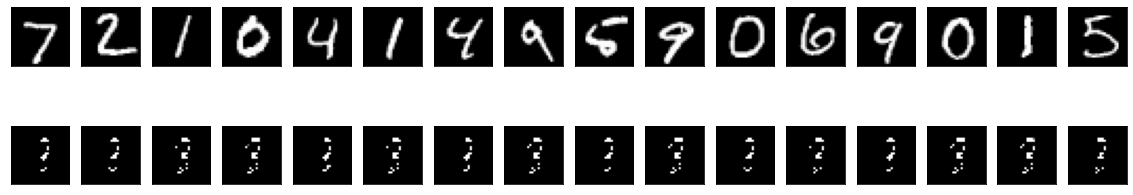

  11: TIME: 71.94 ETA: 6402.71 AE_LOSS: 0.1104 DC_LOSS: 2.2779 DC_ACC: 0.5357 GEN_LOSS: 3.3400
  12: TIME: 82.02 ETA: 7217.70 AE_LOSS: 0.1097 DC_LOSS: 2.1445 DC_ACC: 0.5389 GEN_LOSS: 2.8209
  13: TIME: 71.80 ETA: 6246.52 AE_LOSS: 0.1091 DC_LOSS: 1.9372 DC_ACC: 0.5416 GEN_LOSS: 2.7557
  14: TIME: 82.02 ETA: 7053.97 AE_LOSS: 0.1083 DC_LOSS: 1.7816 DC_ACC: 0.5435 GEN_LOSS: 1.9205
  15: TIME: 82.03 ETA: 6972.60 AE_LOSS: 0.1075 DC_LOSS: 1.7439 DC_ACC: 0.5433 GEN_LOSS: 1.2464
  16: TIME: 82.02 ETA: 6889.99 AE_LOSS: 0.1058 DC_LOSS: 1.6689 DC_ACC: 0.5426 GEN_LOSS: 1.2062
  17: TIME: 82.02 ETA: 6807.67 AE_LOSS: 0.1001 DC_LOSS: 1.5604 DC_ACC: 0.5427 GEN_LOSS: 1.9719
  18: TIME: 82.02 ETA: 6725.62 AE_LOSS: 0.0950 DC_LOSS: 1.4336 DC_ACC: 0.5447 GEN_LOSS: 2.7744
  19: TIME: 82.02 ETA: 6643.76 AE_LOSS: 0.0830 DC_LOSS: 1.5022 DC_ACC: 0.5448 GEN_LOSS: 1.1969
  20: TIME: 82.02 ETA: 6561.55 AE_LOSS: 0.0786 DC_LOSS: 1.5071 DC_ACC: 0.5436 GEN_LOSS: 0.8744


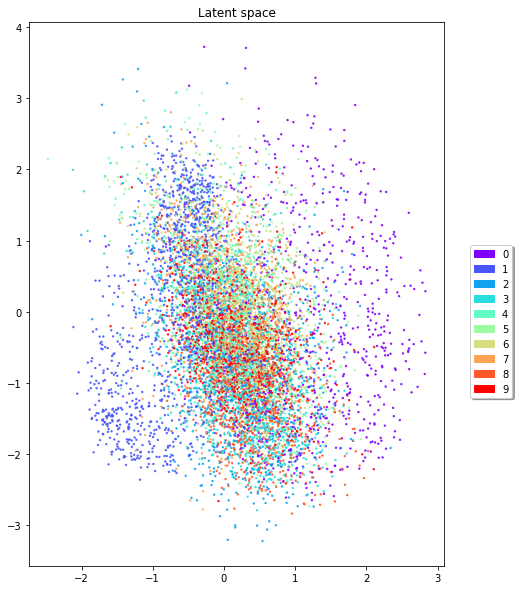

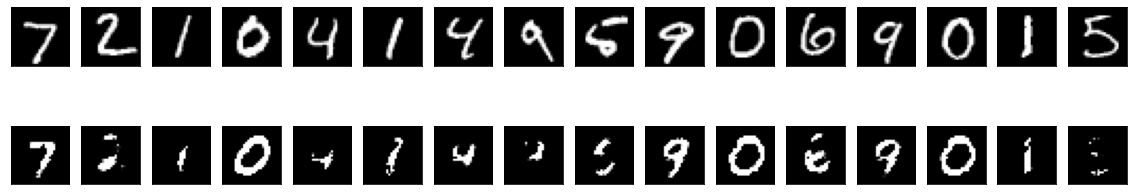

  21: TIME: 82.04 ETA: 6480.82 AE_LOSS: 0.0714 DC_LOSS: 1.4500 DC_ACC: 0.5429 GEN_LOSS: 0.8132
  22: TIME: 82.02 ETA: 6397.85 AE_LOSS: 0.0494 DC_LOSS: 1.1928 DC_ACC: 0.5457 GEN_LOSS: 1.0266
  23: TIME: 82.02 ETA: 6315.79 AE_LOSS: 0.0435 DC_LOSS: 1.1534 DC_ACC: 0.5518 GEN_LOSS: 1.0947
  24: TIME: 72.00 ETA: 5472.33 AE_LOSS: 0.0426 DC_LOSS: 1.1557 DC_ACC: 0.5577 GEN_LOSS: 1.0939
  25: TIME: 82.02 ETA: 6151.66 AE_LOSS: 0.0423 DC_LOSS: 1.2481 DC_ACC: 0.5625 GEN_LOSS: 1.0044
  26: TIME: 82.02 ETA: 6069.35 AE_LOSS: 0.0414 DC_LOSS: 1.3540 DC_ACC: 0.5649 GEN_LOSS: 0.8885
  27: TIME: 82.03 ETA: 5987.84 AE_LOSS: 0.0401 DC_LOSS: 1.3882 DC_ACC: 0.5655 GEN_LOSS: 0.8300
  28: TIME: 71.74 ETA: 5164.96 AE_LOSS: 0.0398 DC_LOSS: 1.3882 DC_ACC: 0.5656 GEN_LOSS: 0.8196
  29: TIME: 71.75 ETA: 5094.58 AE_LOSS: 0.0403 DC_LOSS: 1.4037 DC_ACC: 0.5652 GEN_LOSS: 0.8078
  30: TIME: 70.97 ETA: 4968.08 AE_LOSS: 0.0402 DC_LOSS: 1.4056 DC_ACC: 0.5640 GEN_LOSS: 0.8051


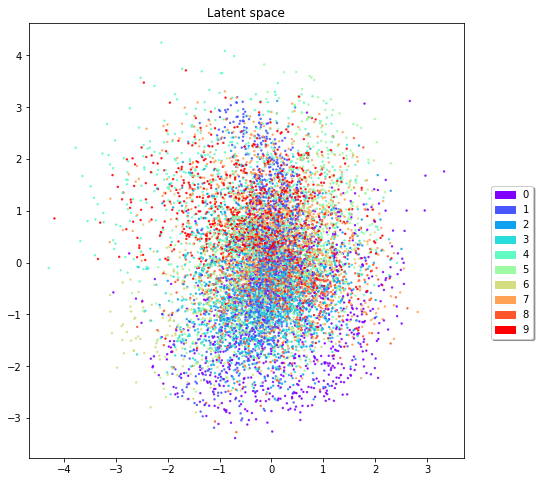

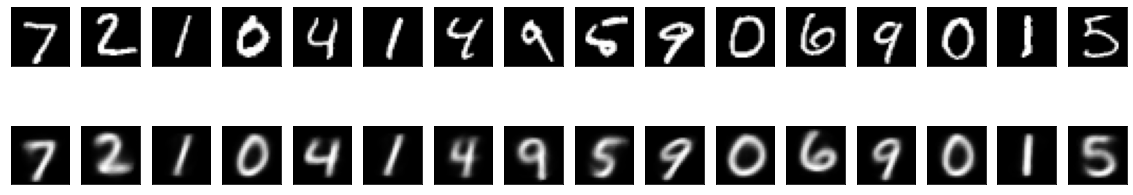

  31: TIME: 82.04 ETA: 5660.80 AE_LOSS: 0.0392 DC_LOSS: 1.4068 DC_ACC: 0.5625 GEN_LOSS: 0.7751
  32: TIME: 82.02 ETA: 5577.59 AE_LOSS: 0.0389 DC_LOSS: 1.4054 DC_ACC: 0.5610 GEN_LOSS: 0.7549
  33: TIME: 82.02 ETA: 5495.64 AE_LOSS: 0.0398 DC_LOSS: 1.3903 DC_ACC: 0.5596 GEN_LOSS: 0.8202
  34: TIME: 71.14 ETA: 4695.39 AE_LOSS: 0.0402 DC_LOSS: 1.3725 DC_ACC: 0.5583 GEN_LOSS: 0.8492
  35: TIME: 82.04 ETA: 5332.30 AE_LOSS: 0.0390 DC_LOSS: 1.3891 DC_ACC: 0.5570 GEN_LOSS: 0.7698
  36: TIME: 82.02 ETA: 5249.40 AE_LOSS: 0.0387 DC_LOSS: 1.3910 DC_ACC: 0.5557 GEN_LOSS: 0.7452
  37: TIME: 72.29 ETA: 4554.28 AE_LOSS: 0.0401 DC_LOSS: 1.3558 DC_ACC: 0.5544 GEN_LOSS: 0.8733
  38: TIME: 71.87 ETA: 4456.24 AE_LOSS: 0.0409 DC_LOSS: 1.3485 DC_ACC: 0.5537 GEN_LOSS: 0.8913
  39: TIME: 82.03 ETA: 5003.90 AE_LOSS: 0.0391 DC_LOSS: 1.3887 DC_ACC: 0.5526 GEN_LOSS: 0.7347
  40: TIME: 82.03 ETA: 4921.94 AE_LOSS: 0.0387 DC_LOSS: 1.3903 DC_ACC: 0.5513 GEN_LOSS: 0.7267


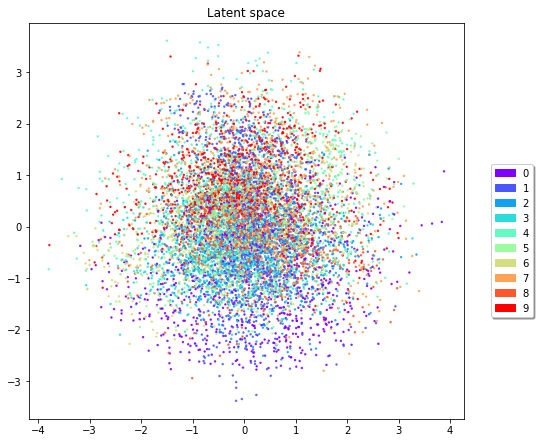

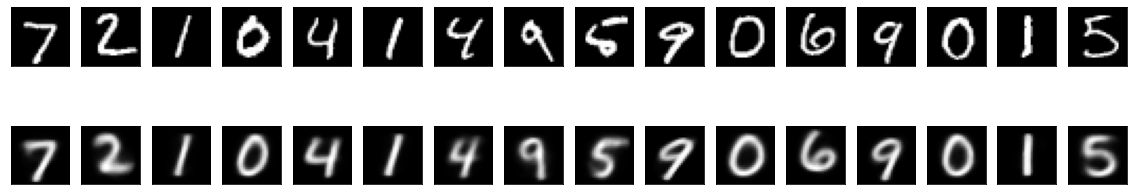

  41: TIME: 82.04 ETA: 4840.59 AE_LOSS: 0.0410 DC_LOSS: 1.3374 DC_ACC: 0.5502 GEN_LOSS: 0.9536
  42: TIME: 71.79 ETA: 4163.89 AE_LOSS: 0.0662 DC_LOSS: 1.2740 DC_ACC: 0.5515 GEN_LOSS: 3.8409
  43: TIME: 82.03 ETA: 4675.98 AE_LOSS: 0.0424 DC_LOSS: 1.3788 DC_ACC: 0.5513 GEN_LOSS: 0.7381
  44: TIME: 82.03 ETA: 4593.42 AE_LOSS: 0.0412 DC_LOSS: 1.3774 DC_ACC: 0.5503 GEN_LOSS: 0.7303
  45: TIME: 82.03 ETA: 4511.60 AE_LOSS: 0.0407 DC_LOSS: 1.3628 DC_ACC: 0.5493 GEN_LOSS: 0.7662
  46: TIME: 82.02 ETA: 4429.21 AE_LOSS: 0.0402 DC_LOSS: 1.3673 DC_ACC: 0.5484 GEN_LOSS: 0.7563
  47: TIME: 82.02 ETA: 4347.29 AE_LOSS: 0.0391 DC_LOSS: 1.3815 DC_ACC: 0.5474 GEN_LOSS: 0.7130
  48: TIME: 82.02 ETA: 4265.10 AE_LOSS: 0.0389 DC_LOSS: 1.3805 DC_ACC: 0.5464 GEN_LOSS: 0.7123
  49: TIME: 82.02 ETA: 4183.26 AE_LOSS: 0.0398 DC_LOSS: 1.3570 DC_ACC: 0.5455 GEN_LOSS: 0.7848
  50: TIME: 82.03 ETA: 4101.54 AE_LOSS: 0.0400 DC_LOSS: 1.3641 DC_ACC: 0.5446 GEN_LOSS: 0.7701


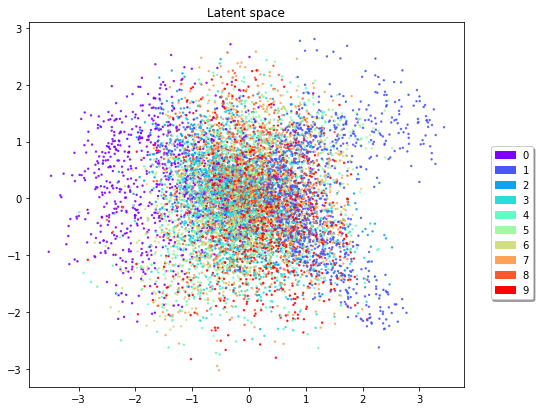

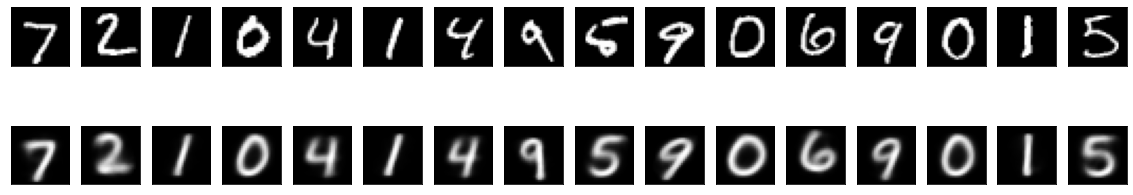

  51: TIME: 82.04 ETA: 4020.19 AE_LOSS: 0.0387 DC_LOSS: 1.3836 DC_ACC: 0.5438 GEN_LOSS: 0.7080
  52: TIME: 82.03 ETA: 3937.24 AE_LOSS: 0.0384 DC_LOSS: 1.3800 DC_ACC: 0.5430 GEN_LOSS: 0.7119
  53: TIME: 82.02 ETA: 3855.09 AE_LOSS: 0.0407 DC_LOSS: 1.3427 DC_ACC: 0.5422 GEN_LOSS: 0.8449
  54: TIME: 82.03 ETA: 3773.16 AE_LOSS: 0.1222 DC_LOSS: 1.1637 DC_ACC: 0.5435 GEN_LOSS: 54.0772
  55: TIME: 82.03 ETA: 3691.21 AE_LOSS: 0.1048 DC_LOSS: 1.2942 DC_ACC: 0.5440 GEN_LOSS: 0.9628
  56: TIME: 71.92 ETA: 3164.40 AE_LOSS: 0.1025 DC_LOSS: 1.2897 DC_ACC: 0.5438 GEN_LOSS: 1.0016
  57: TIME: 82.03 ETA: 3527.33 AE_LOSS: 0.0939 DC_LOSS: 0.8933 DC_ACC: 0.5452 GEN_LOSS: 5.2719
  58: TIME: 72.02 ETA: 3024.82 AE_LOSS: 0.0881 DC_LOSS: 0.8463 DC_ACC: 0.5498 GEN_LOSS: 5.9377
  59: TIME: 82.02 ETA: 3362.78 AE_LOSS: 0.0766 DC_LOSS: 1.0774 DC_ACC: 0.5530 GEN_LOSS: 2.2030
learning rate changed!
  60: TIME: 71.63 ETA: 2865.13 AE_LOSS: 0.0688 DC_LOSS: 1.1686 DC_ACC: 0.5550 GEN_LOSS: 1.4202


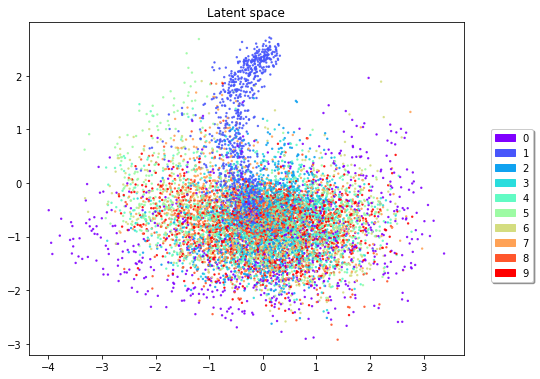

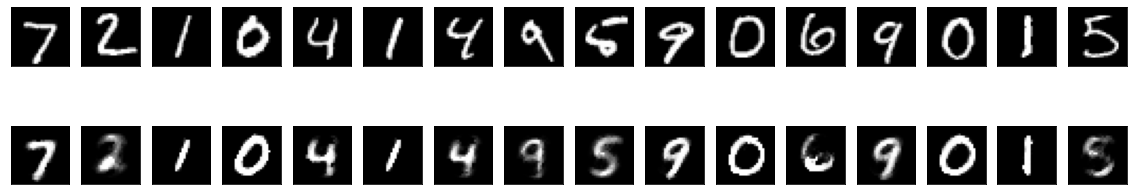

  61: TIME: 82.05 ETA: 3199.76 AE_LOSS: 0.0509 DC_LOSS: 1.2086 DC_ACC: 0.5567 GEN_LOSS: 0.9206
  62: TIME: 70.38 ETA: 2674.41 AE_LOSS: 0.0455 DC_LOSS: 1.1529 DC_ACC: 0.5586 GEN_LOSS: 0.9804
  63: TIME: 82.02 ETA: 3034.78 AE_LOSS: 0.0428 DC_LOSS: 1.2290 DC_ACC: 0.5602 GEN_LOSS: 0.8893
  64: TIME: 82.02 ETA: 2952.64 AE_LOSS: 0.0419 DC_LOSS: 1.2450 DC_ACC: 0.5613 GEN_LOSS: 0.8650
  65: TIME: 71.37 ETA: 2497.94 AE_LOSS: 0.0411 DC_LOSS: 1.3068 DC_ACC: 0.5620 GEN_LOSS: 0.8037
  66: TIME: 71.69 ETA: 2437.34 AE_LOSS: 0.0406 DC_LOSS: 1.3190 DC_ACC: 0.5622 GEN_LOSS: 0.7897
  67: TIME: 71.82 ETA: 2369.98 AE_LOSS: 0.0402 DC_LOSS: 1.3458 DC_ACC: 0.5621 GEN_LOSS: 0.7682
  68: TIME: 82.02 ETA: 2624.73 AE_LOSS: 0.0399 DC_LOSS: 1.3506 DC_ACC: 0.5617 GEN_LOSS: 0.7607
  69: TIME: 71.71 ETA: 2223.13 AE_LOSS: 0.0397 DC_LOSS: 1.3611 DC_ACC: 0.5612 GEN_LOSS: 0.7528
  70: TIME: 82.02 ETA: 2460.71 AE_LOSS: 0.0393 DC_LOSS: 1.3607 DC_ACC: 0.5606 GEN_LOSS: 0.7525


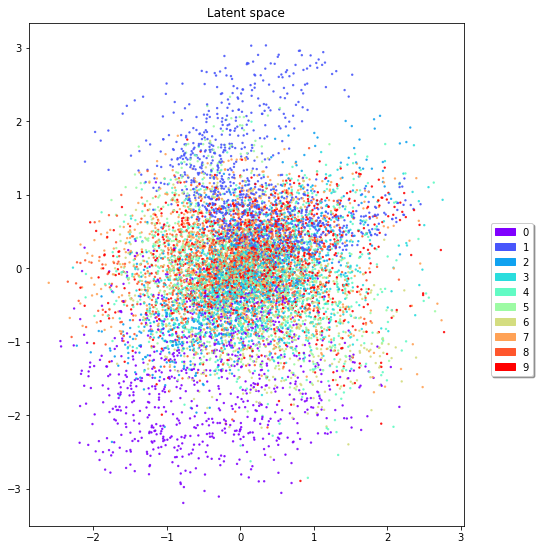

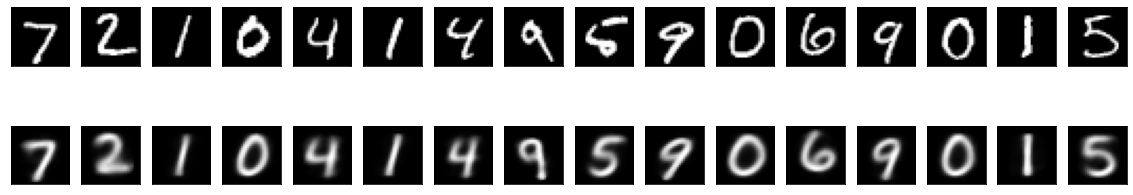

  71: TIME: 82.05 ETA: 2379.55 AE_LOSS: 0.0393 DC_LOSS: 1.3658 DC_ACC: 0.5599 GEN_LOSS: 0.7446
  72: TIME: 71.19 ETA: 1993.45 AE_LOSS: 0.0391 DC_LOSS: 1.3587 DC_ACC: 0.5592 GEN_LOSS: 0.7683
  73: TIME: 71.16 ETA: 1921.21 AE_LOSS: 0.0392 DC_LOSS: 1.3627 DC_ACC: 0.5585 GEN_LOSS: 0.7577
  74: TIME: 82.02 ETA: 2132.53 AE_LOSS: 0.0389 DC_LOSS: 1.3566 DC_ACC: 0.5577 GEN_LOSS: 0.7663
  75: TIME: 82.03 ETA: 2050.69 AE_LOSS: 0.0390 DC_LOSS: 1.3693 DC_ACC: 0.5571 GEN_LOSS: 0.7426
  76: TIME: 82.03 ETA: 1968.60 AE_LOSS: 0.0389 DC_LOSS: 1.3513 DC_ACC: 0.5563 GEN_LOSS: 0.7977
  77: TIME: 82.03 ETA: 1886.79 AE_LOSS: 0.0401 DC_LOSS: 1.3335 DC_ACC: 0.5560 GEN_LOSS: 0.8765
  78: TIME: 72.68 ETA: 1598.94 AE_LOSS: 0.0390 DC_LOSS: 1.3572 DC_ACC: 0.5553 GEN_LOSS: 0.7782
  79: TIME: 71.44 ETA: 1500.32 AE_LOSS: 0.0388 DC_LOSS: 1.3760 DC_ACC: 0.5547 GEN_LOSS: 0.7185
  80: TIME: 82.02 ETA: 1640.40 AE_LOSS: 0.0387 DC_LOSS: 1.3657 DC_ACC: 0.5541 GEN_LOSS: 0.7576


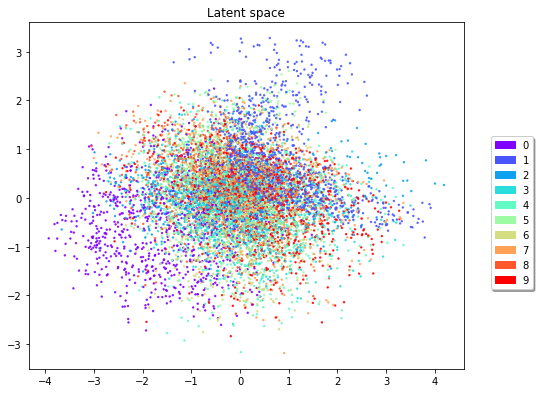

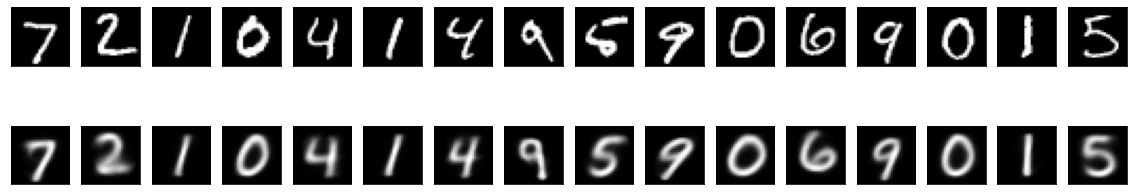

  81: TIME: 82.05 ETA: 1558.87 AE_LOSS: 0.0389 DC_LOSS: 1.3699 DC_ACC: 0.5534 GEN_LOSS: 0.7383
  82: TIME: 71.48 ETA: 1286.69 AE_LOSS: 0.0388 DC_LOSS: 1.3671 DC_ACC: 0.5528 GEN_LOSS: 0.7623
  83: TIME: 82.03 ETA: 1394.43 AE_LOSS: 0.0393 DC_LOSS: 1.3662 DC_ACC: 0.5523 GEN_LOSS: 0.7570
  84: TIME: 82.03 ETA: 1312.43 AE_LOSS: 0.0441 DC_LOSS: 1.4217 DC_ACC: 0.5517 GEN_LOSS: 0.8706
  85: TIME: 82.03 ETA: 1230.51 AE_LOSS: 0.0491 DC_LOSS: 1.4253 DC_ACC: 0.5513 GEN_LOSS: 0.8492
  86: TIME: 72.68 ETA: 1017.58 AE_LOSS: 0.0420 DC_LOSS: 1.3793 DC_ACC: 0.5509 GEN_LOSS: 0.7051
  87: TIME: 73.38 ETA: 953.88 AE_LOSS: 0.0400 DC_LOSS: 1.3870 DC_ACC: 0.5503 GEN_LOSS: 0.7019
  88: TIME: 82.03 ETA: 984.33 AE_LOSS: 0.0393 DC_LOSS: 1.3822 DC_ACC: 0.5497 GEN_LOSS: 0.7014
  89: TIME: 71.26 ETA: 783.86 AE_LOSS: 0.0391 DC_LOSS: 1.3866 DC_ACC: 0.5492 GEN_LOSS: 0.7026
  90: TIME: 82.02 ETA: 820.20 AE_LOSS: 0.0386 DC_LOSS: 1.3841 DC_ACC: 0.5486 GEN_LOSS: 0.6982


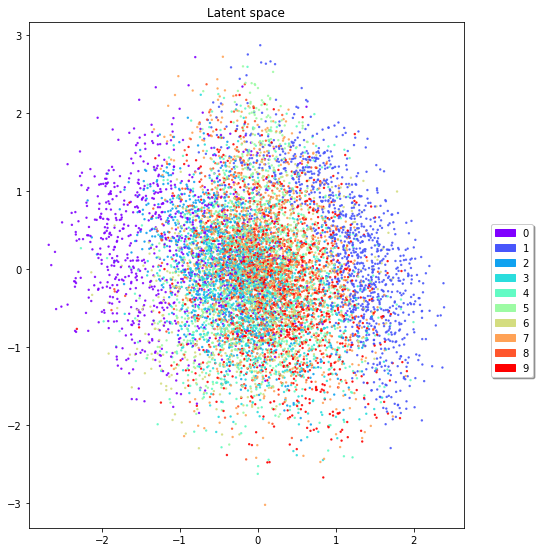

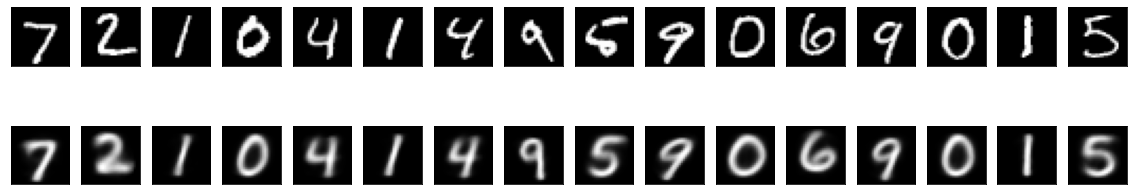

  91: TIME: 72.99 ETA: 656.92 AE_LOSS: 0.0394 DC_LOSS: 1.3807 DC_ACC: 0.5482 GEN_LOSS: 0.7276
  92: TIME: 82.03 ETA: 656.21 AE_LOSS: 0.0385 DC_LOSS: 1.3859 DC_ACC: 0.5477 GEN_LOSS: 0.6963
  93: TIME: 82.02 ETA: 574.16 AE_LOSS: 0.0387 DC_LOSS: 1.3843 DC_ACC: 0.5471 GEN_LOSS: 0.7052
  94: TIME: 71.70 ETA: 430.21 AE_LOSS: 0.0382 DC_LOSS: 1.3841 DC_ACC: 0.5467 GEN_LOSS: 0.6974
  95: TIME: 82.02 ETA: 410.11 AE_LOSS: 0.0525 DC_LOSS: 1.4413 DC_ACC: 0.5461 GEN_LOSS: 0.8257
  96: TIME: 82.03 ETA: 328.12 AE_LOSS: 0.0421 DC_LOSS: 1.3844 DC_ACC: 0.5456 GEN_LOSS: 0.7067
  97: TIME: 70.89 ETA: 212.66 AE_LOSS: 0.0393 DC_LOSS: 1.3877 DC_ACC: 0.5452 GEN_LOSS: 0.6996
  98: TIME: 82.04 ETA: 164.09 AE_LOSS: 0.0387 DC_LOSS: 1.3852 DC_ACC: 0.5447 GEN_LOSS: 0.6944
  99: TIME: 82.03 ETA: 82.03 AE_LOSS: 0.0387 DC_LOSS: 1.3870 DC_ACC: 0.5443 GEN_LOSS: 0.6982


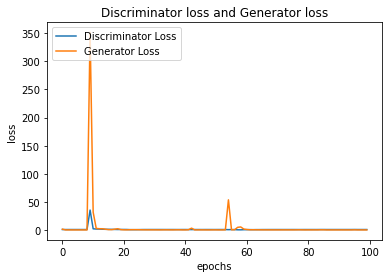

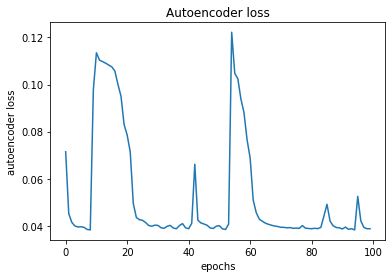

In [ ]:
# -------------------------------------------------------------------------------------------------------------
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the dataset
x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))

# -------------------------------------------------------------------------------------------------------------
# Create the dataset iterator
batch_size = 256
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

# -------------------------------------------------------------------------------------------------------------
# Create models
image_size = 784
h_dim = 1000
z_dim = 2
n_labels = 10

def make_encoder_model():
    inputs = tf.keras.Input(shape=(image_size,))
    x = tf.keras.layers.Dense(h_dim)(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(h_dim)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    encoded = tf.keras.layers.Dense(z_dim)(x)
    model = tf.keras.Model(inputs=inputs, outputs=encoded)
    return model


def make_decoder_model():
    encoded = tf.keras.Input(shape=(z_dim + n_labels,))
    x = tf.keras.layers.Dense(h_dim)(encoded)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(h_dim)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    reconstruction = tf.keras.layers.Dense(image_size, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=encoded, outputs=reconstruction)
    return model


def make_discriminator_model():
    encoded = tf.keras.Input(shape=(z_dim,))
    x = tf.keras.layers.Dense(h_dim)(encoded)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(h_dim)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    prediction = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=encoded, outputs=prediction)
    return model


encoder = make_encoder_model()
decoder = make_decoder_model()
discriminator = make_discriminator_model()

# -------------------------------------------------------------------------------------------------------------
# Define loss functions
ae_loss_weight = 1.
gen_loss_weight = 1.
dc_loss_weight = 1.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.BinaryAccuracy()


def autoencoder_loss(inputs, reconstruction, loss_weight):
    return loss_weight * mse(inputs, reconstruction)


def discriminator_loss(real_output, fake_output, loss_weight):
    loss_real = cross_entropy(tf.ones_like(real_output), real_output)
    loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return loss_weight * (loss_fake + loss_real)


def generator_loss(fake_output, loss_weight):
    return loss_weight * cross_entropy(tf.ones_like(fake_output), fake_output)


# -------------------------------------------------------------------------------------------------------------
# Define cyclic learning rate
base_lr = 0.00025
max_lr = 0.0025

n_samples = 60000
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0

# -------------------------------------------------------------------------------------------------------------
# Define optimizers
ae_optimizer = tf.keras.optimizers.Adam(lr=base_lr)
dc_optimizer = tf.keras.optimizers.Adam(lr=base_lr)
gen_optimizer = tf.keras.optimizers.Adam(lr=base_lr)


# -------------------------------------------------------------------------------------------------------------
# Training function
@tf.function
def train_step(batch_x, batch_y):
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch_x, training=True)
        decoder_output = decoder(tf.concat([encoder_output, tf.one_hot(batch_y, n_labels)], axis=1), training=True)

        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, decoder_output, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, encoder.trainable_variables + decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, encoder.trainable_variables + decoder.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([batch_x.shape[0], z_dim], mean=0.0, stddev=1.0)
        encoder_output = encoder(batch_x, training=True)

        dc_real = discriminator(real_distribution, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Discriminator Loss
        dc_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

        # Discriminator Acc
        dc_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, discriminator.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, discriminator.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoder_output = encoder(batch_x, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Generator loss
        gen_loss = generator_loss(dc_fake, gen_loss_weight)

    gen_grads = gen_tape.gradient(gen_loss, encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss


# -------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 100
dcloss = []
genloss = []
aeloss = []

for epoch in range(n_epochs):
    start = time.time()

    # Learning rate schedule
    if epoch in [60, 100, 300]:
        base_lr = base_lr / 2
        max_lr = max_lr / 2
        step_size = step_size / 2

        print('learning rate changed!')

    epoch_ae_loss_avg = tf.metrics.Mean()
    epoch_dc_loss_avg = tf.metrics.Mean()
    epoch_dc_acc_avg = tf.metrics.Mean()
    epoch_gen_loss_avg = tf.metrics.Mean()

    for batch, (batch_x, batch_y) in enumerate(train_dataset):
        # -------------------------------------------------------------------------------------------------------------
        # Calculate cyclic learning rate
        global_step = global_step + 1
        cycle = np.floor(1 + global_step / (2 * step_size))
        x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
        ae_optimizer.lr = clr
        dc_optimizer.lr = clr
        gen_optimizer.lr = clr

        ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x, batch_y)

        epoch_ae_loss_avg(ae_loss)
        epoch_dc_loss_avg(dc_loss)
        epoch_dc_acc_avg(dc_acc)
        epoch_gen_loss_avg(gen_loss)
    
    dcloss.append(epoch_dc_loss_avg.result())
    genloss.append(epoch_gen_loss_avg.result())
    aeloss.append(epoch_ae_loss_avg.result())
    epoch_time = time.time() - start
    print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))
  # -------------------------------------------------------------------------------------------------------------
    if epoch % 10 == 0:
        # Latent space of test set
        x_test_encoded = encoder(x_test, training=False)
        label_list = list(y_test)
        fig = plt.figure(figsize=(10, 10))
        classes = set(label_list)
        colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
        kwargs = {'alpha': 0.8, 'c': [colormap[i] for i in label_list]}
        ax = plt.subplot(111, aspect='equal')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
                   for i, class_ in enumerate(classes)]
        ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
                  fancybox=True, loc='center left')
        plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], s=2, **kwargs)
        #ax.set_xlim([-3, 3])
        #ax.set_ylim([-3, 3])
        plt.title("Latent space")
        plt.show()

        #plt.savefig(latent_space_dir / ('epoch_%d.png' % epoch))
        #plt.close('all')

        # Reconstruction
        n_digits = 16  # how many digits we will display
        x_test_decoded = decoder(
            tf.concat([x_test_encoded[:n_digits], tf.one_hot(y_test[:n_digits], n_labels)], axis=1), training=False)

        x_test_decoded = np.reshape(x_test_decoded, [-1, 28, 28])*255
        fig = plt.figure(figsize=(20, 4))
        for i in range(n_digits):
            # display original
            ax = plt.subplot(2, n_digits, i + 1)
            plt.imshow(x_test[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n_digits, i + 1 + n_digits)
            plt.imshow(x_test_decoded[i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        plt.show()

t = np.arange(0, n_epochs, 1)
plt.title("Discriminator loss and Generator loss")
plt.plot(t, dcloss)
plt.plot(t, genloss)  
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['Discriminator Loss', 'Generator Loss'], loc = 'upper left')
plt.show()

plt.title("Autoencoder loss")
plt.plot(t, aeloss)
plt.xlabel("epochs")
plt.ylabel("autoencoder loss")
plt.show()

Use TSNE

In [ ]:
from sklearn.manifold import TSNE
x_test_encoded = encoder(x_test, training=False)
x_test_decoded = decoder(
            tf.concat([x_test_encoded, tf.one_hot(y_test, n_labels)], axis=1), training=False)

x_test_decoded = np.reshape(x_test_decoded, [-1, 28, 28])*255
tsne = TSNE(random_state=42)
fitted = tsne.fit_transform(x_test_decoded.reshape(-1,28*28))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Org data dimension is 28. Embedded data dimension is 2


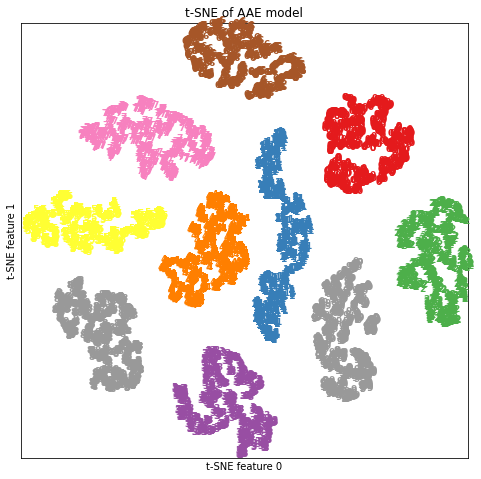

In [ ]:
print("Org data dimension is {}. Embedded data dimension is {}".format(x_test_decoded.shape[-1], fitted.shape[-1]))
      

x_min, x_max = fitted.min(0), fitted.max(0)
fitted = (fitted - x_min) / (x_max - x_min)  # normalization 
plt.figure(figsize=(8, 8))
for i in range(fitted.shape[0]):
    plt.text(fitted[i, 0], fitted[i, 1], str(y_test[i]), color=plt.cm.Set1(y_test[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.title("t-SNE of AAE model")
plt.show()